### 3_使用Keras对波士顿房价数据集进行回归

- 标签：回归、Keras、Boston Housing Prices
- 难度：🌟🌟
- 参考：[https://www.tensorflow.org/tutorials/keras/basic_regression](https://www.tensorflow.org/tutorials/keras/basic_regression)
- 协议：MIT License

加载库，包括深度学习框架keras、用于数值计算的numpy、用于处理格式化数据的pandas、用于绘图的matplotlib

In [1]:
import keras
from keras.datasets import boston_housing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


加载房价数据并随机打乱训练集，如果没有则下载

- 训练集和测试集分别包含404和102条数据，每条数据包括13个特征字段
- 标签为对应的房价，以千美元为单位

In [2]:
(X_train, Y_train), (X_test, Y_test) = boston_housing.load_data()
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

order = np.argsort(np.random.random(X_train.shape[0]))
X_train = X_train[order]
Y_train = Y_train[order]

(404, 13) (404,) (102, 13) (102,)


13个字段对应的含义

- Per capita crime rate.
- The proportion of residential land zoned for lots over 25,000 square feet.
- The proportion of non-retail business acres per town.
- Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
- Nitric oxides concentration (parts per 10 million).
- The average number of rooms per dwelling.
- The proportion of owner-occupied units built before 1940.
- Weighted distances to five Boston employment centers.
- Index of accessibility to radial highways.
- Full-value property-tax rate per 10,000 dollars.
- Pupil-teacher ratio by town.
- 1000 (Bk - 0.63) * 2 where Bk is the proportion of Black people by town.
- Percentage lower status of the population.

既然是格式化数据，不妨用pandas将其转换为DataFrame，给每一列特征加上名称

In [3]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df = pd.DataFrame(X_train, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.07875,45.0,3.44,0.0,0.437,6.782,41.1,3.7886,5.0,398.0,15.2,393.87,6.68
1,4.55587,0.0,18.10,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12
2,0.09604,40.0,6.41,0.0,0.447,6.854,42.8,4.2673,4.0,254.0,17.6,396.90,2.98
3,0.01870,85.0,4.15,0.0,0.429,6.516,27.7,8.5353,4.0,351.0,17.9,392.43,6.36
4,0.52693,0.0,6.20,0.0,0.504,8.725,83.0,2.8944,8.0,307.0,17.4,382.00,4.63


对房价值绘制直方图，查看一下房价的分布情况

- 房价为20千刀的记录最多，呈现中间多、两边少的分布趋势
- 部分房子的价格在45～50千刀

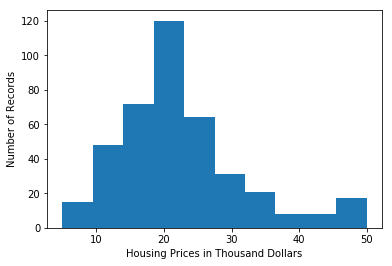

In [4]:
plt.hist(Y_train)
plt.xlabel('Housing Prices in Thousand Dollars')
plt.ylabel('Number of Records')
plt.show()

将数据进行归一化，基于训练集计算每一列特征的均值和方差，然后对训练集和测试集都进行归一化

In [5]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

print(np.max(X_train), np.min(X_train), np.max(X_test), np.min(X_test))

9.234847178400434 -3.8172503201932804 4.135832294709217 -3.5122566958337686


定义一个获取模型的函数，包括三层全连接层

- 因为是回归问题，所以最后一层Dense只需要一个神经元
- 损失函数为MSE即mean squared error，而分类问题中一般是交叉熵crossentropy
- 评估指标为MAE即mean absolute error，而分类问题中一般是正确率accuracy

In [6]:
def get_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model
    
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


训练模型，共训练500个epochs，从训练集中随机选择20%作为验证集，verbose=0表示不打印训练信息

In [7]:
epochs = 500
history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.2, verbose=0)

定义一个绘制训练过程历史数据的函数，在训练集和测试集上评估模型，可以看到过拟合比较明显

- 训练集的MSE和MAE分别为4.71和1.42
- 测试集的MSE和MAE分别为18.08和2.98

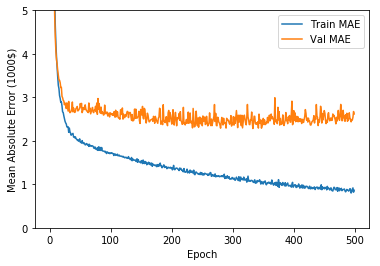

404/404 [==============================] - 0s 37us/step
[4.7140315594059405, 1.4165430352239325]
102/102 [==============================] - 0s 45us/step
[18.076928232230394, 2.9842111176135493]


In [8]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (1000$)')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label='Val MAE')
    plt.legend()
    plt.ylim([0, 5])
    plt.show()

plot_history(history)

print(model.evaluate(X_train, Y_train))
print(model.evaluate(X_test, Y_test))

重新再训练一次模型并增加回调函数callbacks

- 回调函数会在每个epoch结束后运行
- 提前停止（early stop）能在一定程度上避免过拟合，如果验证集损失连续20个epochs没有降低则提前停止训练，避免过拟合进一步加剧
- 从结果来看，过拟合问题确实得到了缓解

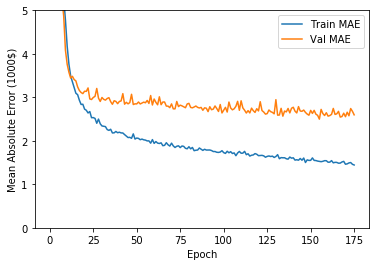

404/404 [==============================] - 0s 30us/step
[5.925066929052372, 1.6308811914802779]
102/102 [==============================] - 0s 62us/step
[16.241846720377605, 2.53954106686162]


In [9]:
model = get_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[early_stop])

plot_history(history)

print(model.evaluate(X_train, Y_train))
print(model.evaluate(X_test, Y_test))